In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 街景分割 (pytorch)

支援python 版本: 3.5以上    
支援pytorch版本 : 1.4以上

許多人小時候都曾經幻想過自己是霹靂遊俠的李麥克，能夠有一台自動駕駛的「夥計」，而如今這個夢想已經不算是太遙遠，我們今天要做的實作就是教各位如何賦予汽車視覺，最普遍的做法是透過分割模型，將機器視野的圖片進行分割，並且針對各區域進行識別，這樣汽車才知道路在那裏，哪裡有行人得小心注意。下圖是我們這次實作所使用的原圖以及標注結果。 

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import densenet


trident 0.7.1


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


Opencv version:4.1.2.
Pillow version:7.1.2.


這次採用的數據集是Cambridge-driving Labeled Video Database (http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/ )，他實際上就是真實的汽車駕駛過程的街景，裏面包含了原圖已經標註的遮罩圖(mask)。

<img src="../images/streetview_image.png">
<img src="../images/streetview_mask.png">

為了達到良好的建模效果，輸入多尺度的圖片是非常重要的，因此在trident api中特別設計了RandomMultiScaleImage資料轉換，他整合了固定/變動長寬比的Resize，RandomRescaleCrop, RandomCenterCrop以及RandomCrop這5種操作，透過隨機抽選的方式，這樣可以確保所有圖片都能有均勻多樣的縮放形式可以納入樣本，而且每一種都能讓圖片、遮罩、標註框、特徵點的空間位置都能對應一致。

In [3]:
data_provider=load_examples_data('autodrive')
data_provider.paired_transform_funcs=[RandomMultiScaleImage((224, 224),scale=(0.5,1.2))]
data_provider.image_transform_funcs=[
                     AddNoise(0.01),
                     RandomBlur(),
                     RandomAdjustGamma(value_scale=(0.8,1.5)),
                     RandomAdjustContrast(value_scale=(0.6, 1.5)),
                     RandomAdjustSaturation(value_scale=(0.6, 1.5)),
                     RandomAdjustHue(value_scale=(-0.5,0.5)),
                     Normalize(0,255),
                     Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]

archive file is already existing, donnot need download again.
Starting to decompress the archive....
get autodrive images :701


data_provider可以透過preview_images來預覽處理過的圖片。

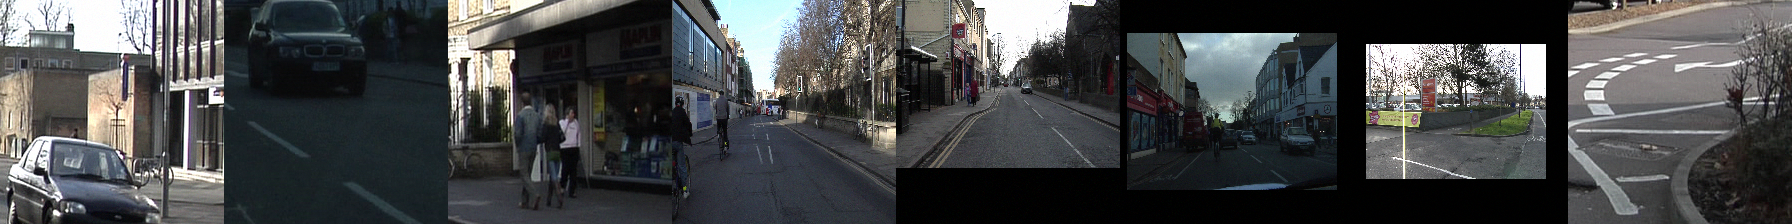

In [4]:
data_provider.preview_images()

所有標注類別對應的顏色，紀錄在label_colors.txt中(可以在~\.trident\datasets\examples_autodrive目錄下找到)，我們讀取出來並且產生定義清單。這邊顏色的排序為(R,G,B)，與我們的圖片標準一致，若是您另外使用opencv處理數據，則需要自行轉換順序，例如路面上的汽車是紫色，opencv的BGR應該是(128,0,64)。在trident api中，Mask類的數據來源有專用的MaskDataset，它可以處理二元遮罩、標籤遮罩(基於索引值區分類別)以及色彩遮罩(基於顏色區分類別)，在這個範例中正是色彩遮罩，透過MaskDataset讀取色彩遮罩圖片，會自動處理將它轉換為對於建模有用的標籤遮罩。自動處理主要是調用了trident.data.mask_common中的color2label以及label2color函數。

In [5]:
print(data_provider.traindata.palette)

{ Void: (0, 0, 0), Building: (128, 0, 0), Tree: (128, 128, 0), Sky: (128, 128, 128), Car: (64, 0, 128), Archway: (192, 0, 128), SignSymbol: (192, 128, 128), Road: (128, 64, 128), Pedestrian: (64, 64, 0), Wall: (64, 192, 0), VegetationMisc: (192, 192, 0), Fence: (64, 64, 128), Train: (192, 64, 128), ParkingBlock: (64, 192, 128), Column_Pole: (192, 192, 128), TrafficCone: (0, 0, 64), Bridge: (0, 128, 64), Misc_Text: (128, 128, 64), Sidewalk: (0, 0, 192), LaneMkgsDriv: (128, 0, 192), Bicyclist: (0, 128, 192), RoadShoulder: (128, 128, 192), Tunnel: (64, 0, 64), LaneMkgsNonDriv: (192, 0, 64), Animal: (64, 128, 64), Child: (192, 128, 64), CartLuggagePram: (64, 0, 192), MotorcycleScooter: (192, 0, 192), SUVPickupTruck: (64, 128, 192), Truck_Bus: (192, 128, 192), TrafficLight: (0, 64, 64), OtherMoving: (128, 64, 64) }


定義fcn-densenet，也就是俗稱的提拉米蘇。基本上它是以Densenet為基礎，總共包含兩個路徑，一個是逐步進行下採樣讓圖片縮小(TD,  transition down)，另外一個路徑則是逐步將縮小的圖片進行上採樣來復原(TU, transition up)，在尺寸對應的的層，會透過skip connection將較完整清晰的特徵從TD路徑傳至TU路徑，以確保細節特徵的完整性。

<img src="../images/dense_connection.png">

<img src="../images/tiramisu.jpg">

由於我們這次並沒有使用預訓練模型來做微調，必須從零開始，那意味著我們需要花更多的訓練資源才能做到一樣的效果，但我們這次又有一個限制是數據集只有701張圖片，在沒有預訓練又圖片數量少(還好圖片標註品質很好)，就必須從模型結構設計下手才有可能做到較好的預測效果。以下是我針對這樣的情況做的一些調整：  
1. 使用DenseNetFcn就是一個較佳的選擇，因為DenseNet強調的是特徵的重複使用，整個網路中不斷地進行特徵篩選、特徵重新加入，以及各種尺度特徵的混合，所以利用這樣的網路結構比較不容易發生過擬合。  
2. 過擬合很容易發生的一個主因是使用了與數據不相襯的參數規模，尤其是越複雜(參數越多的網路)只能靠更龐大的數據集才有可能訓練的好，也因此，原始論文的tiramisu 103的blocks參數是(4,5,7,10,12,15)我把它下調到(4, 5, 6, 7, 8)，原本原始參數TransitionDown共使用了5次(len(blocks)-1)，我則是使用4次，然後讓第一層的卷積透過strides=2分擔掉一次下採樣的任務，這樣也可以減少非常大量的計算量。
3. 原本的TransitionDown是利用一個3x3常規卷積搭配MaxPool，基本上我們課程介紹過，使用池化是比較古老的做法了，現在都建議使用Strides=2來替代池化。此外，為了降低計算量，我把常規卷積置換為Depthwise卷積，也可以大幅縮小計算的參數數量。同時也加入了0.2的dropout，以增加模型的強健程度避免過擬合。
4. 數據增強中使用了MultiScaleImage，兼顧多種多尺度的圖片切取技術，確保不同縮放尺度都能有好的效果。
5. 使用了多損失函數策略。一開始先用DiceLoss這種基於類別的損失函數來達到快速的損失下降(多分類的DiceLoss是計算每個類別的損失後平均，因此本身是不易受到分布不均衡影響)，但是DiceLoss雖然能讓整體模型有快速收斂的效果，卻無法作精細的調整，所以還需要同時加入損失函數CrossEntropyLoss來做細部的調整，但由於CrossEntropyLoss是計算每顆像素的CrossEntropyLoss後平均，因此會嚴重受到類別不均衡的影響。所以最後在第5個epoch後加入FocalLoss，來處理最後類別不均衡的分類錯誤。這樣分層次的多損失函數策略可以讓模型分階段調整，以確保模型整體效果。



In [6]:
tiramisu=densenet.DenseNetFcn(blocks=(4, 5, 6, 7, 8),growth_rate=16, initial_filters=32,num_classes=32)

#tiramisu.load_model('Models/tiramisu_1.pth.tar')

In [7]:
tiramisu.with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(DiceLoss)\
    .with_loss(CrossEntropyLoss)\
    .with_loss(IoULoss)\
    .with_loss(FocalLoss,1,start_epoch=3)\
    .with_metric(pixel_accuracy,name='pixel_accuracy')\
    .with_metric(iou,name='iou')\
    .with_regularizer('l2',reg_weight=1e-6)\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/tiramisu.pth')\
    .adjust_learning_rate_scheduling(5,'epoch',5e-4)\
    .adjust_learning_rate_scheduling(10,'epoch',2e-4)\
    .adjust_learning_rate_scheduling(15,'epoch',5e-5)\
    .adjust_learning_rate_scheduling(20,'epoch',2e-5)\
    .adjust_learning_rate_scheduling(25,'epoch',5e-6)\
    .with_callbacks(SegTileImageCallback(batch_inteval=20,reverse_image_transform=data_provider.reverse_image_transform,palette=data_provider.traindata.palette))\
    .with_automatic_mixed_precision_training()
#在模型中設定
#with_optimizer 設定優化器為Ranger
#with_loss(DiceLoss) 加入Dice loss損失函數(類別層級)
#with_loss(CrossEntropyLoss)加入交叉熵作為損失函數(像素層級)
#with_loss(FocalLoss,start_epoch=5)加入FocalLoss作為損失函數(像素層級)解決類別不均衡問題，於epoch=5時開始納入計算
#with_metric(pixel_accuracy) 加入像素正確率metrics
#with_metric(iou,name='iou') 加入iou作為metrics
#with_regularizer('l2')\ 加入l2正則
#with_constraint('max_min_norm')\ 加入max_min_norm權重正則
#with_learning_rate_scheduler(reduce_lr_on_plateau) 加入reduce_lr_on_plateau學習率變化原則(指標不再變動時，學習率下降)
#with_model_save_path('Models/deeplab_seg.pth') 設定模型存檔路徑
#with_callbacks 加入SegTileImageCallback來繪製比較用的tile images

tiramisu.summary()

DiceLoss( output, target) -> DiceLoss 
CrossEntropyLoss( output, target) -> CrossEntropyLoss 
IoULoss( output, target) -> IoULoss 
FocalLoss( output, target) -> FocalLoss 
pixel_accuracy( output, target) -> pixel_accuracy 
iou( output, target) -> iou 
Automatic Mixed Precision:Turn On.
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
first_layer.conv  [Conv2d]                         [None, 32, 112, 112]       [32, 3, 3, 3]                  864  21,663,488.0  
first_layer.norm  [BatchNorm]                      [None, 32, 112, 112]       [32]                 [32]      64  1,191,680.0  
first_layer  [Conv2d_Block]                        [None, 32, 112, 112]                                      0  0.0  
denseblock_down1.denselayer1.norm  [BatchNorm]     [None, 32, 112

ImageSegmentationModel(
  (inputs): TensorSpec(shape=(None, 3, 224, 224), ndim=4, name=input)
  (_outputs): TensorSpec(shape=(None, 32, 224, 224), ndim=4, name=output)
  (_targets): TensorSpec(shape=(None, 32, 224, 224), ndim=4, name=target)
  (_losses): <trident.optims.pytorch_losses.DiceLoss object at 0x000001C172E20748>
  (_losses): <trident.optims.pytorch_losses.CrossEntropyLoss object at 0x000001C172E20828>
  (_losses): <trident.optims.pytorch_losses.IoULoss object at 0x000001C172E20898>
  (_losses): <trident.optims.pytorch_losses.FocalLoss object at 0x000001C172E20908>
  (_metrics): functools.partial(<function pixel_accuracy at 0x000001C16BFDE730>)
  (_metrics): functools.partial(<function iou at 0x000001C16BFDE950>)
  (loss_weights): 1.0
  (loss_weights): 1.0
  (loss_weights): 1.0
  (loss_weights): 1.0
  (_regs): functools.partial(<function l2_reg at 0x000001C16AE6FBF8>, reg_weight=1e-06)
  (_constraints): functools.partial(<function min_max_norm at 0x000001C16AE6F950>)
)

In [8]:
plan=TrainingPlan()\
    .add_training_item(tiramisu,name='tiramisu')\
    .with_data_loader(data_provider)\
    .repeat_epochs(50)\
    .with_batch_size(4)\
    .print_progress_scheduling(5,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=50,unit='batch',imshow=True)\
    .save_model_scheduling(20,unit='batch')\

#add_training_item加入要訓練的模型
#with_data_loader加入數據提供者
#repeat_epochs設定要執行的epoch數量
#within_minibatch_size設定minibatch_size
#print_progress_scheduling設定列印進度的頻率
#display_loss_metric_curve_scheduling設定顯示損失函數曲線的頻率
#save_model_scheduling設定存檔的頻率

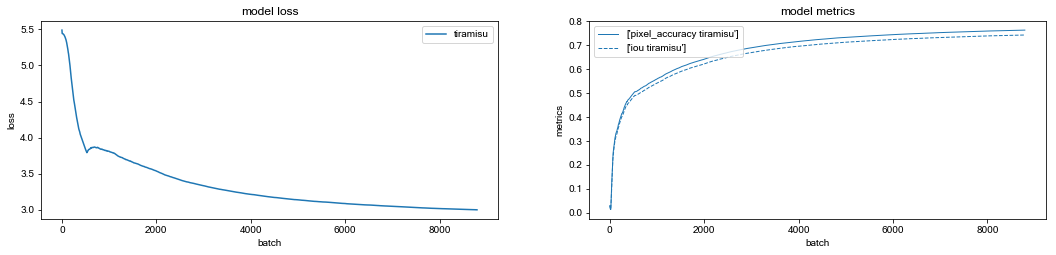

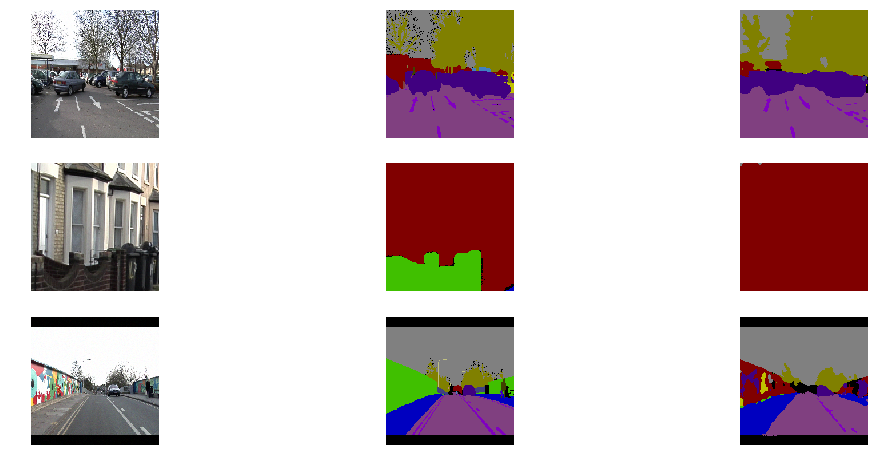

tiramisu     Step: 10s407ms | Loss: 3.001 | pixel_accuracy: 76.370% , iou: 74.323%  | lr: 5.000e-06  | epoch: 49  ( 175/176 )


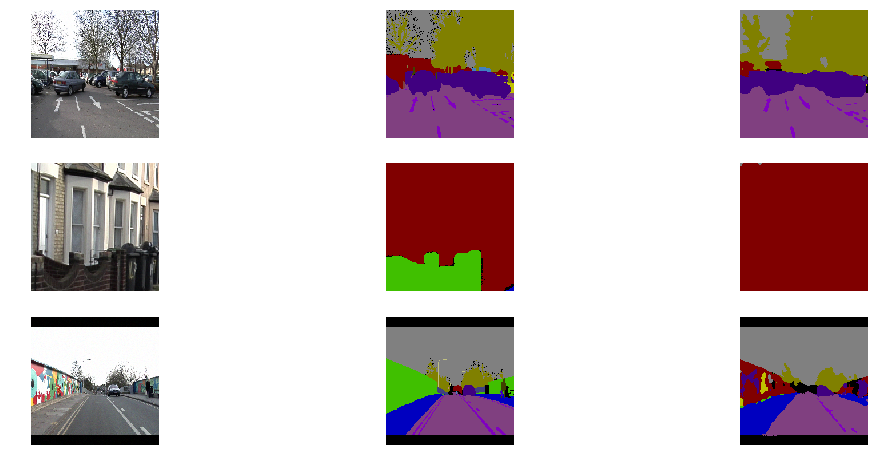

In [9]:
plan.start_now()

In [11]:
tiramisu.eval()
tiramisu.save_onnx('Models/tiramisu2.onnx')